## GF180MCU process - i-v Curves

### Disable auto-scrolling

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Simulation

In [2]:
%%writefile .spiceinit
set ngbehavior=hs
set ng_nomodcheck
set color0=white
set color1=black
set xbrushwidth=2

Overwriting .spiceinit


In [3]:
%%writefile netlist_iv.spice
* ivCurves_gf130 
*

** spice model 
.include "/Users/talarico/share/openmpw/pdk_gf180/gf180mcuC/libs.tech/ngspice/design.ngspice"
.lib "/Users/talarico/share/openmpw/pdk_gf180/gf180mcuC/libs.tech/ngspice/sm141064.ngspice" typical

** options
.options nomod delmax=5p relv=1e-6 relmos=1e-6 method=gear

** parameters
.global gnd
.param gs=1 ds=1

** temperature
.TEMP 27
** hspice  default TNOM=25
** ngspice default TNOM=27
** eldo    default TNOM=27
** spectre default TNOM=27

** transistor geometrical dimensions
.param L1 = 0.28u
.param width = 10u

** netlist
Vdsn dn gnd 'ds'
Vgsn gn gnd 'gs'
Vsdp gnd dp 'ds'
Vsgp gnd gp 'gs'

xmn dn gn gnd gnd nfet_03v3 L='L1' W='width' 
+ AD={width*0.24u} AS={width*0.24u} 
+ PD={2*(width + 0.24u)} PS={2*(width + 0.24u)}

xmp dp gp gnd gnd pfet_03v3 L='L1' W='width' 
+ AD={width*0.24u} AS={width*0.24u}
+ PD={2*(width + 0.24u)} PS={2*(width + 0.24u)}

.op  

.control
save v(dn) v(gn) @m.xmn.m0[id]
dc vdsn 0 1.8 0.01 vgsn 0.2 1.8 0.2
let id_n=@m.xmn.m0[id]
write ./spiceout/iv_nmos_gf180.raw id_n v(dn) v(gn)

save v(dp) v(gp) @m.xmp.m0[id]
dc vsdp 0 1.8 0.01 vsgp 0.2 1.8 0.2
let id_p=@m.xmp.m0[id]
write ./spiceout/iv_pmos_gf180.raw id_p v(dp) v(gp)
.endc

.end


Overwriting netlist_iv.spice


In [4]:
!ngspice -b netlist_iv.spice


Note: Compatibility modes selected: hs



Circuit: * ivcurves_gf130 

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 1629
binary raw file "./spiceout/iv_nmos_gf180.raw"
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 1629
binary raw file "./spiceout/iv_pmos_gf180.raw"
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 1
	Node                                  Voltage
	----                                  -------
	----	-------
	gp                               -1.00000e+00
	dp                               -1.00000e+00
	gn                               1.000000e+00
	dn                               1.000000e+00

	Source	Current
	------	-------

	@m.xmp.m0[id]                    6.315497e-05
	@m.xmn.m0[id]                    3.317278e-04
	vdsn#branch                      -3.31728e-04
	vgsn#branch                      0.000000e+00
	vsdp#branch                      -6.31550e-05
	vsgp#branch               

### Read and process the simulation data

In [5]:
# PyPlot_iv_gf180.py

import sys
import matplotlib.pyplot as plt
from PyLTSpice import RawRead

# read simulation output (nmos)
LTR = RawRead("./spiceout/iv_nmos_gf180.raw") 

print(LTR.get_trace_names())
print("\n")
print(LTR.get_raw_property())
print("\n")
steps = LTR.get_steps()
num_steps = len(steps) 
print('number of sweeps in the simulation:', num_steps)

# objects containing the data
vdn = LTR.get_trace('v(dn)')
vgn = LTR.get_trace('v(gn)')
idn = LTR.get_trace('i(id_n)')

#extract the data from the object
if num_steps == 1:
    VD_N = vdn.get_wave(0)
    VG_N = vgn.get_wave(0)
    ID_N  = idn.get_wave(0)
    
vd_veclen = len(VD_N)
vg_veclen = len(VG_N)
id_veclen = len(ID_N)

m = int((1.8-0)/0.01 + 1)  # number of vd sweeping points in spice simulation
n = int((1.8-0.2)/0.2 + 1) # number of vg sweeping points in spice simulation
k = m*n

if vd_veclen != vg_veclen or vg_veclen != id_veclen:
  print("DATA VECTORS ARE NOT of THE SAME LENGTH!")
  sys.exit(0)
  
if k != vd_veclen:
  print("THE NUMBER OF DATA POINTS IS INCONSISTENT!")
  sys.exit(0)


Reading file with encoding  utf_8
File contains 4 traces, reading 4
Binary RAW file with Normal access
['v(v-sweep)', 'i(id_n)', 'v(dn)', 'v(gn)']


OrderedDict([('Filename', PosixPath('spiceout/iv_nmos_gf180.raw')), (' * ivcurves_gf130 ', ''), ('Date', 'Wed Dec  6 14:13:09  2023'), ('Plotname', 'DC transfer characteristic'), ('Flags', 'real'), ('No. Variables', 4), ('No. Points', 1629), ('Variables', ['v(v-sweep)', 'i(id_n)', 'v(dn)', 'v(gn)'])])


number of sweeps in the simulation: 1


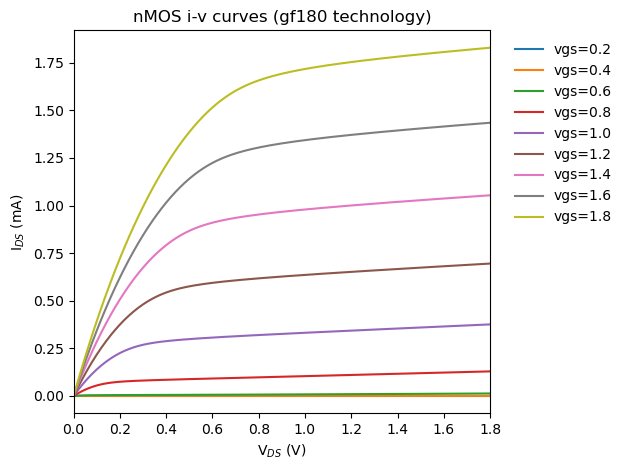

In [6]:
fig1 = plt.figure()
for i in range(n):
    vds = VD_N[0+m*i:m+m*i]
    ids = ID_N[0+m*i:m+m*i]
    plt.plot(vds,1e3*ids, label = 'vgs=%.1f' %VG_N[m*i])
    
plt.xlim(0,1.8)
plt.xlabel('V$_{DS}$ (V)')
plt.ylabel('I$_{DS}$ (mA)')
plt.title('nMOS i-v curves (gf180 technology)')
plt.legend(loc="best",frameon=False,
           bbox_to_anchor=(1.03, 1.0))
plt.tight_layout()
plt.show() 

In [7]:
# read simulation output (pmos)
LT = RawRead("./spiceout/iv_pmos_gf180.raw")
 
print(LT.get_trace_names())
print("\n")
print(LT.get_raw_property())
print("\n")
steps = LT.get_steps()
num_steps = len(steps) 
print('number of sweeps in the simulation:', num_steps)

# objects containing the data
vdp = LT.get_trace('v(dp)')
vgp = LT.get_trace('v(gp)')
idp = LT.get_trace('i(id_p)')

#extract the data from the object
if num_steps == 1:
    VD_P = vdp.get_wave(0)
    VG_P = vgp.get_wave(0)
    ID_P = idp.get_wave(0)
    
# The simulation sweeps done for the nmos and pmos are the same 
# no need to recompute and recheck the structure of the data points     

Reading file with encoding  utf_8
File contains 4 traces, reading 4
Binary RAW file with Normal access
['v(v-sweep)', 'i(id_p)', 'v(dp)', 'v(gp)']


OrderedDict([('Filename', PosixPath('spiceout/iv_pmos_gf180.raw')), (' * ivcurves_gf130 ', ''), ('Date', 'Wed Dec  6 14:13:09  2023'), ('Plotname', 'DC transfer characteristic'), ('Flags', 'real'), ('No. Variables', 4), ('No. Points', 1629), ('Variables', ['v(v-sweep)', 'i(id_p)', 'v(dp)', 'v(gp)'])])


number of sweeps in the simulation: 1


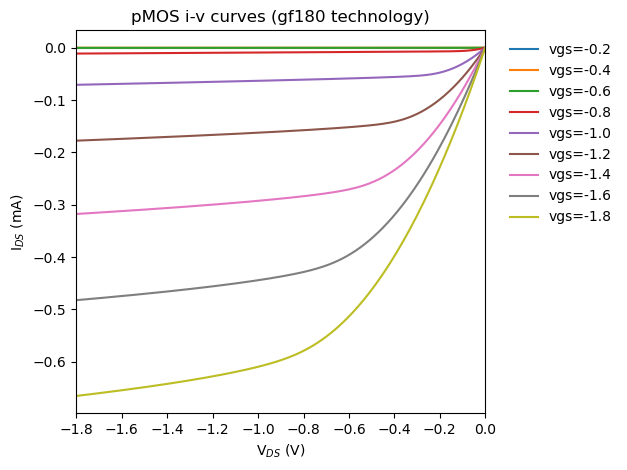

In [8]:
fig2 = plt.figure()
for i in range(n):
    vds = VD_P[0+m*i:m+m*i]
    ids = -ID_P[0+m*i:m+m*i] # must flip sign
    plt.plot(vds,1e3*ids, label = 'vgs=%.1f' %VG_P[m*i])        
plt.xlim(-1.8,0)
plt.xlabel('V$_{DS}$ (V)')
plt.ylabel('I$_{DS}$ (mA)')
plt.title('pMOS i-v curves (gf180 technology)')
plt.legend(loc="best",frameon=False,
               bbox_to_anchor=(1.03, 1.0))
plt.tight_layout()
plt.show()           